Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing lime (its not pre-instaled on colab)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=159941944d884d35ce9207473e06a08f3ed7f14a8bc48ac98eb9623e7040de0d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Installing other dependencies (Its not pre-installed if you are using TPU)

Imports

In [ ]:
import tensorflow as tf
from tf_keras.models import Sequential, Model, load_model
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Input, SpatialDropout2D, GaussianNoise
from tf_keras.regularizers import l2
from tf_keras.metrics import Precision, Recall, AUC
from tf_keras import layers, models
from tf_keras.utils import array_to_img
from tf_keras.preprocessing import image
from tf_keras.callbacks import EarlyStopping
from tf_keras.optimizers import Adam, AdamW
from tf_keras.applications import EfficientNetB0,Xception
from tf_keras import regularizers
from tf_keras.mixed_precision import set_global_policy
from tf_keras.callbacks import (
    ReduceLROnPlateau,
    ModelCheckpoint,
    TerminateOnNaN
)
from tf_keras.activations import swish, tanh
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
import os
import random
import shutil
import pickle

Small functions that will be used all around the code

In [ ]:
#Count total images in a dataset
def count_images(dataset):
    total = 0
    for images, _ in dataset:
        total += images.shape[0]
    return total

# Função para rescale
def rescale_image(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image


#Prepare the dataset
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False):

    ds = ds.map(lambda x, y: (rescale_image(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)

    return ds.prefetch(buffer_size=AUTOTUNE)

#Prepare a single image
def prepare_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def display_single_image(img_path, img_size, print_shape = False):
  '''Displays an image, and depending on need, can print the input shape'''

  # Load Image
  img = image.load_img(img_path, target_size= img_size)
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)

  # Light preprocessing
  img_tensor /= 255.

  # Print the shape
  if print_shape:
    print(img_tensor.shape)

  # Display the image
  plt.imshow(img_tensor[0])
  plt.axis('off')
  plt.show()

def plot_graphs(history):
  # Gráfico de Loss
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Gráfico de Acurácia
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend()
  plt.show()

#Show the classification report for the model
def model_evaluation(model, test_ds, class_names=["AI-Generated Images", "Real Images"]):
    y_true = []
    y_pred = []
    batch_count = 0

    for images, labels in test_ds:
        batch_count += 1
        print(f"Processando batch {batch_count}")

        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose=0)
        y_pred.extend((predictions > 0.5).astype(int).flatten())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

#Test function for a single image
def test_single_image(image_path, model):

  processed_img = rescale_image(image_path)
  prediction = model.predict(processed_img)

  if prediction[0][0] > 0.5:
    print("Imagem real. (Probabilidade: {:.2f}%)".format(prediction[0][0] * 100))
  else:
    print("Deepfake detectado! (Probabilidade: {:.2f}%)".format((1 - prediction[0][0]) * 100))

Counting all the images on the dataset and display them organized

In [ ]:
base_path = '/content/drive/MyDrive/TCC-Dataset/split'
folders = {
    'train': os.path.join(base_path, 'train'),
    'test': os.path.join(base_path, 'test'),
    'val': os.path.join(base_path, 'val')
}

extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

counts = {
    'real': {'train': 0, 'test': 0, 'val': 0, 'total': 0},
    'fake': {'train': 0, 'test': 0, 'val': 0, 'total': 0}
}

for split in ['train', 'test', 'val']:
    real_path = os.path.join(folders[split], 'real')
    fake_path = os.path.join(folders[split], 'fake')

    if os.path.exists(real_path):
        counts['real'][split] = sum(
            1 for file in os.listdir(real_path)
            if file.lower().endswith(extensions)
        )
        counts['real']['total'] += counts['real'][split]

    if os.path.exists(fake_path):
        counts['fake'][split] = sum(
            1 for file in os.listdir(fake_path)
            if file.lower().endswith(extensions)
        )
        counts['fake']['total'] += counts['fake'][split]

print("=== Contagem de Imagens ===")
print(f"TOTAL REAIS: {counts['real']['total']}")
print(f"TOTAL FAKES: {counts['fake']['total']}\n")

print("Detalhes por pasta:")
for split in ['train', 'test', 'val']:
    print(f"\n[{split.upper()}]")
    print(f"Reais: {counts['real'][split]}")
    print(f"Fakes: {counts['fake'][split]}")
    print(f"Total: {counts['real'][split] + counts['fake'][split]}")

=== Contagem de Imagens ===
TOTAL REAIS: 22035
TOTAL FAKES: 21560

Detalhes por pasta:

[TRAIN]
Reais: 15424
Fakes: 15092
Total: 30516

[TEST]
Reais: 3306
Fakes: 3234
Total: 6540

[VAL]
Reais: 3305
Fakes: 3234
Total: 6539


Changing dataset size (Moving images to another directory)

In [ ]:
# Caminhos principais
base_path = '/content/drive/MyDrive/TCC-Dataset/split'
backup_path = '/content/drive/MyDrive/TCC-Dataset/backup'

# Certificar que a pasta de backup existe
for split in ['train', 'val', 'test']:
    for label in ['real', 'fake']:
        os.makedirs(os.path.join(backup_path, split, label), exist_ok=True)

# Estrutura de pastas reais e fakes
paths = {
    'real': {
        'train': os.path.join(base_path, 'train', 'real'),
        'val': os.path.join(base_path, 'val', 'real'),
        'test': os.path.join(base_path, 'test', 'real')
    },
    'fake': {
        'train': os.path.join(base_path, 'train', 'fake'),
        'val': os.path.join(base_path, 'val', 'fake'),
        'test': os.path.join(base_path, 'test', 'fake')
    }
}

# Quantidade a mover por categoria e por pasta
move_counts = {
    'train': 7000,
    'val': 1500,
    'test': 1500
}

# Extensões válidas
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

# Total movidos por categoria
total_moved = {'real': 0, 'fake': 0}

def mover_imagens(tipo):
    for split, origem in paths[tipo].items():
        destino = os.path.join(backup_path, split, tipo)

        if not os.path.exists(origem):
            print(f"[ERRO] Pasta não encontrada: {origem}")
            continue

        # Listar e embaralhar imagens
        imagens = [f for f in os.listdir(origem) if f.lower().endswith(valid_extensions)]
        random.shuffle(imagens)

        mover_qtd = min(move_counts[split], len(imagens))
        print(f"[{split.upper()}][{tipo.upper()}] Movendo {mover_qtd} de {len(imagens)} imagens...")

        for img in imagens[:mover_qtd]:
            try:
                shutil.move(os.path.join(origem, img), os.path.join(destino, img))
                total_moved[tipo] += 1
            except Exception as e:
                print(f"Erro ao mover {img}: {e}")

# Mover imagens reais e fakes
mover_imagens('real')
mover_imagens('fake')

# Resultado final
print(f"\n Total de imagens movidas:")
print(f"Reais: {total_moved['real']}")
print(f"Fakes: {total_moved['fake']}")

Taking images from one directory and organize them on the dataset directory

In [ ]:
# Caminho da pasta base
wiki_base_path = '/content/drive/MyDrive/TCC-Dataset/wiki'
output_base_path = '/content/drive/MyDrive/TCC-Dataset/split'

# Destinos finais
destinations = {
    'train': os.path.join(output_base_path, 'train', 'real'),
    'val': os.path.join(output_base_path, 'val', 'real'),
    'test': os.path.join(output_base_path, 'test', 'real')
}

# Criar pastas de destino se não existirem
for path in destinations.values():
    os.makedirs(path, exist_ok=True)

# Extensões válidas
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

# Coletar todas as imagens das subpastas
all_images = []
for subfolder in sorted(os.listdir(wiki_base_path)):
    subfolder_path = os.path.join(wiki_base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.lower().endswith(valid_extensions):
                full_path = os.path.join(subfolder_path, file)
                all_images.append(full_path)

# Embaralhar as imagens
random.shuffle(all_images)

# Separar
total = len(all_images)
train_split = int(0.7 * total)
val_split = int(0.85 * total)

train_images = all_images[:train_split]
val_images = all_images[train_split:val_split]
test_images = all_images[val_split:]

# Função para copiar imagens
def copy_images(image_list, destination):
    for img_path in image_list:
        filename = os.path.basename(img_path)
        dest_path = os.path.join(destination, filename)
        shutil.copy2(img_path, dest_path)  # Use shutil.move(...) para mover em vez de copiar

# Copiar imagens
copy_images(train_images, destinations['train'])
copy_images(val_images, destinations['val'])
copy_images(test_images, destinations['test'])

# Exibir resumo
print(f"Total de imagens encontradas: {total}")
print(f"Treino: {len(train_images)}")
print(f"Validação: {len(val_images)}")
print(f"Teste: {len(test_images)}")

Loading the dataset and dividing them into train/val/test (0.7/0.15/0.15) + Normalization

In [ ]:
# Caminhos
base_path = '/content/drive/MyDrive/TCC-Dataset/split'

# Parâmetros
batch_size = 32
img_height = 224
img_width = 224
AUTOTUNE = tf.data.AUTOTUNE

# Normalização
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Dataset de treino
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{base_path}/train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Dataset de validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{base_path}/val',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Dataset de teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    f'{base_path}/test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Aplicar normalização
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Otimização do pipeline
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 30516 files belonging to 2 classes.
Found 6539 files belonging to 2 classes.
Found 6540 files belonging to 2 classes.


In [ ]:
# Caminhos
base_path = '/content/drive/MyDrive/TCC-Dataset/split'

# Parâmetros
batch_size = 32
img_height = 299 #Necessario mudar dependendo do modelo
img_width = 299 #Necessario mudar dependendo do modelo
AUTOTUNE = tf.data.AUTOTUNE

# Normalização
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Dataset de treino
test2_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'  # ou 'categorical' para multi-classes
)
test2_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test2_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 9651 files belonging to 2 classes.


Processando batch 1
Processando batch 2
Processando batch 3
Processando batch 4
Processando batch 5
Processando batch 6
Processando batch 7
Processando batch 8
Processando batch 9
Processando batch 10
Processando batch 11
Processando batch 12
Processando batch 13
Processando batch 14
Processando batch 15
Processando batch 16
Processando batch 17
Processando batch 18
Processando batch 19
Processando batch 20
Processando batch 21
Processando batch 22
Processando batch 23
Processando batch 24
Processando batch 25
Processando batch 26
Processando batch 27
Processando batch 28
Processando batch 29
Processando batch 30
Processando batch 31
Processando batch 32
Processando batch 33
Processando batch 34
Processando batch 35
Processando batch 36
Processando batch 37
Processando batch 38
Processando batch 39
Processando batch 40
Processando batch 41
Processando batch 42
Processando batch 43
Processando batch 44
Processando batch 45
Processando batch 46
Processando batch 47
Processando batch 48
P

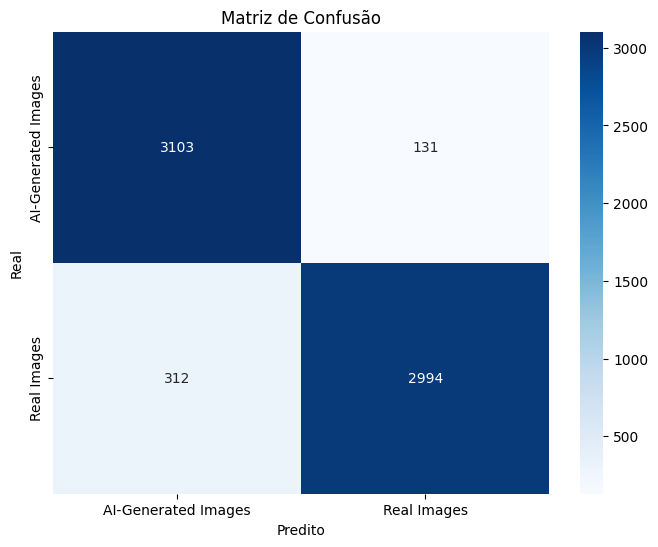

In [ ]:
model_evaluation(model, test2_ds)

Printing the class names to see if its all correct

In [ ]:
print(test_ds.class_names)

Printing the dataset to see the shape and scale of images, and other useful information

In [ ]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


Plotting a single image to see what happens after the rescale

     Original Image Resolution
----------------------------------
(1, 160, 160, 3)


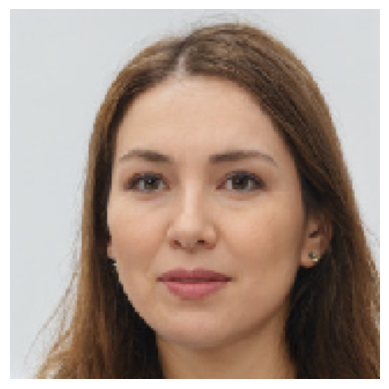

  Resolution After Preprocessing
----------------------------------
(1, 64, 64, 3)


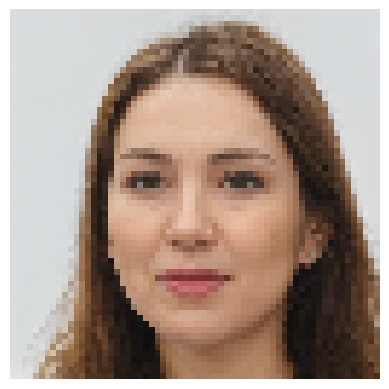

In [ ]:
img_path = '/content/drive/MyDrive/TCC-Dataset/Human Faces Dataset/AI-Generated Images/000001.jpg'
img_size = (160, 160)
img_size2 = (64, 64)

print("     Original Image Resolution")
print('----------------------------------')
display_single_image(img_path, img_size, print_shape = True)

print("  Resolution After Preprocessing")
print('----------------------------------')
display_single_image(img_path, img_size2, print_shape = True)


Basic CNN Model (64x64)


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', name = 'last_conv_layer'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  Precision(name='precision'),
                  Recall(name='recall'),
                  AUC(name='auc')
    ]
)

print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

basic_history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
    callbacks=[early_stopping]
)

Saving the model

In [ ]:
model.save('/content/drive/MyDrive/TCC-Dataset/Models/basic_model.keras')

with open('/content/drive/MyDrive/TCC-Dataset/History/basic_history.pkl', 'wb') as f:
    pickle.dump(basic_history.history, f)

Enhanced CNN Model (64x64)

In [ ]:
callback = EarlyStopping(
    monitor='val_accuracy',
    patience=4, mode='max',
    min_delta=0.0,
    restore_best_weights=True)

new_model = Sequential()

new_model.add(Conv2D(128, (3,3), activation='relu', input_shape=(64, 64 , 3)))
new_model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
new_model.add(MaxPooling2D((2,2)))

new_model.add(Conv2D(64, (3,3), activation='tanh'))
new_model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
new_model.add(MaxPooling2D((2,2)))

new_model.add(Conv2D(32, (3,3), activation='tanh'))
new_model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
new_model.add(MaxPooling2D((2,2)))

new_model.add(Conv2D(16, (3,3), activation='tanh'))
new_model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
new_model.add(MaxPooling2D((2,2)))

new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

new_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

print(new_model.summary())

enhanced_history= new_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=15,
    batch_size = 32,
    callbacks = callback,
)

new_model.save('/content/drive/MyDrive/TCC-Dataset/Models/enhanced_model.keras')

with open('/content/drive/MyDrive/TCC-Dataset/History/enhanced_history.pkl', 'wb') as f:
    pickle.dump(enhanced_history.history, f)

Saving the model / Saving training history

In [ ]:
new_model.save('/content/drive/MyDrive/TCC-Dataset/Models/enhanced_model(backup).keras')

with open('/content/drive/MyDrive/TCC-Dataset/History/enhanced_history(backup).pkl', 'wb') as f:
    pickle.dump(enhanced_history.history, f)

Xception Model (150x150)

In [ ]:
callback = EarlyStopping(
    monitor='val_acc',
    patience=3,
    mode='max',
    restore_best_weights=True
)

model_xception = Sequential()

conv_base = Xception(weights = 'imagenet', include_top = False, input_shape=(150, 150, 3),
                     classifier_activation = 'softmax')
conv_base.trainable = False

model_xception.add(conv_base)

model_xception.add(Flatten())

model_xception.add(Dense(16, activation = 'relu'))
model_xception.add(Dense(32, activation = 'relu'))
model_xception.add(Dense(64, activation = 'relu'))
model_xception.add(Dense(128, activation = 'relu'))
model_xception.add(Dense(256, activation = 'relu'))

model_xception.add(Dense(1, activation = 'sigmoid'))

model_xception.compile(optimizer = 'adam',
                       loss = 'binary_crossentropy',
                       metrics = ['acc'])

print(model_xception.summary())

xception_history = model_xception.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = [callback]
)

model_xception.save('/content/drive/MyDrive/TCC-Dataset/Models/xception_model.keras')

with open('/content/drive/MyDrive/TCC-Dataset/History/xception_history.pkl', 'wb') as f:
    pickle.dump(xception_history.history, f)

Existing Xception Model for comparison (299x299)

*Needed some changes to work on our dataset

In [ ]:
# Early Stopping
callback = EarlyStopping(monitor = 'val_acc', patience = 3, mode = 'max',
                         min_delta = .01, restore_best_weights = True, verbose = 2)

# Create model
model_3 = Sequential()

# Create the base with Xception
conv_base = Xception(weights = 'imagenet', include_top = True,
                     classifier_activation = 'softmax')
conv_base.trainable = False
model_3.add(conv_base)

model_3.add(Flatten())

# Add Dense Layers
model_3.add(Dense(256, activation = 'tanh'))
model_3.add(Dense(128, activation = 'tanh'))
model_3.add(Dense(64, activation = 'tanh'))
model_3.add(Dense(32, activation = 'tanh'))
model_3.add(Dense(16, activation = 'tanh'))

# Output layer
model_3.add(Dense(1, activation = 'sigmoid'))

# Compile
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['acc'])

# Get the model summary
print(model_3.summary())

# Fit Model
history_3 = model_3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 25,
    callbacks = [callback]
)

ViT Model (224x224)

In [ ]:
SAVE_DIR = '/content/drive/MyDrive/TCC-Dataset/ModelTraining'

# Hiperparâmetros
input_shape = (224, 224, 3)
num_classes = 1
patch_size = 16
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
transformer_units = [projection_dim * 2, projection_dim]  # FFN
transformer_layers = 8
num_heads = 4
mlp_head_units = [256, 128]  # cabeça final

# Camada para dividir a imagem em patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Camada de embedding dos patches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

inputs = layers.Input(shape=input_shape)
augmented = layers.Rescaling(1./255)(inputs)

patches = Patches(patch_size)(augmented)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

# Transformer blocks
for _ in range(transformer_layers):
    # Layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Multi-head Self Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
    x3 = layers.Dropout(0.1)(x3)
    x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)
    x3 = layers.Dropout(0.1)(x3)
    encoded_patches = layers.Add()([x3, x2])

# Classificação
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
for units in mlp_head_units:
    representation = layers.Dense(units, activation="relu")(representation)
    representation = layers.Dropout(0.5)(representation)

outputs = layers.Dense(1, activation="sigmoid")(representation)

vit_model = Model(inputs=inputs, outputs=outputs)

vit_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

vit_model.summary()
vit_model.save(os.path.join(SAVE_DIR, 'ViT_Model.keras'))


Hybrid model (ViT + Xception) (224x224)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import xception

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('hybrid_model.keras', save_best_only=True),
    TerminateOnNaN()
]

SAVE_DIR = '/content/drive/MyDrive/TCC-Dataset/ModelTraining'

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 1

PATCH_SIZE = 16
PROJECTION_DIM = 256
NUM_HEADS = 8
TRANSFORMER_LAYERS = 8
FFN_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.1

#Fine-tunning
FINE_TUNE_AT = -20

# --- Componentes do ViT (reutilizando do código anterior) ---
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# --- Create hybrid model ---

def create_hybrid_model():

    # Uma única entrada que será usada por ambos os ramos.
    inputs = layers.Input(shape=INPUT_SHAPE, name="input_image")

    # Pré-processamento específico para a Xception
    xception_preprocessed = xception.preprocess_input(inputs)

    # Carrega a base da Xception
    xception_base = xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling=None
    )

    # Congela a base para não destruir os pesos durante o treino inicial
    xception_base.trainable = False

    cnn_features = xception_base(xception_preprocessed, training=False)
    cnn_features = layers.GlobalAveragePooling2D(name="cnn_global_pooling")(cnn_features)


    #  ViT

    # Calcula o número de patches
    num_patches = (INPUT_SHAPE[0] // PATCH_SIZE) ** 2

    # Normaliza os pixels para o ViT (0-1)
    vit_rescaled = layers.Rescaling(1./255)(inputs)

    # Criação dos Patches
    patches = Patches(PATCH_SIZE, name="vit_patches")(vit_rescaled)

    # Codificação dos Patches (Projeção Linear + Embedding de Posição)
    encoded_patches = PatchEncoder(num_patches, PROJECTION_DIM, name="vit_patch_encoder")(patches)

    # Blocos Transformer
    for i in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS, dropout=DROPOUT_RATE
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = layers.Dense(FFN_UNITS[0], activation=tf.nn.gelu)(x3)
        x4 = layers.Dropout(DROPOUT_RATE)(x4)
        x4 = layers.Dense(FFN_UNITS[1])(x4)
        x4 = layers.Dropout(DROPOUT_RATE)(x4)
        encoded_patches = layers.Add()([x4, x2])

    # Representação final do ViT (pooling)
    vit_representation = layers.LayerNormalization(epsilon=1e-6, name="vit_layer_norm")(encoded_patches)
    vit_features = layers.GlobalAveragePooling1D(name="vit_global_pooling")(vit_representation)


    # --- Model Fusion ---

    # Concatena os vetores de características da CNN e do ViT
    merged_features = layers.Concatenate(name="feature_fusion")([cnn_features, vit_features])

    x = layers.Dense(512, activation="relu")(merged_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="output_classifier")(x)

    # Cria o modelo final
    model = keras.Model(inputs=inputs, outputs=outputs, name="Hybrid_Xception_ViT")

    for layer in model.get_layer('xception').layers[FINE_TUNE_AT:]:
        layer.trainable = True

    return model

hybrid_model = create_hybrid_model()

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
hybrid_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

hybrid_model.summary()

history = hybrid_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)


hybrid_model.save(os.path.join(SAVE_DIR, 'hibrid_model_final.keras'))

Plotting single image to see if the images on the dataset are correct

In [ ]:
for images, labels in val_ds.take(1):
    plt.imshow(images[0].numpy())
    plt.title("IA" if labels[0].numpy() == 1 else "Humano")
    plt.axis("off")
    plt.show()

Testing the performance of the Models

In [ ]:
model_evaluation(model, test_ds)

Plotting the loss/acc graphs of a model after training

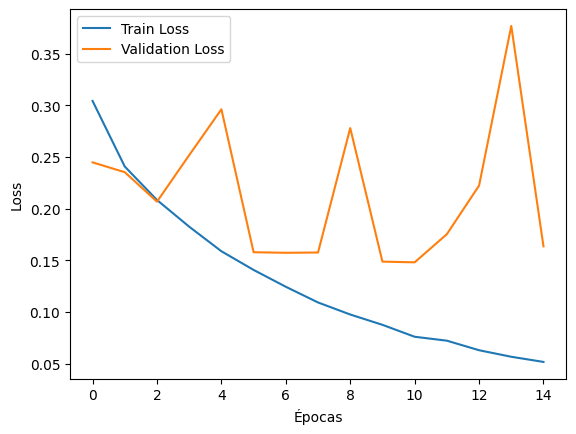

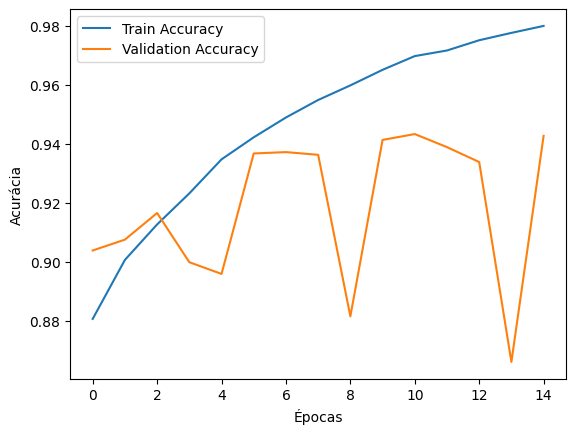

In [ ]:
# Gráfico de Loss
plt.plot(enhanced_history.history['loss'], label='Train Loss')
plt.plot(enhanced_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de Acurácia
plt.plot(enhanced_history.history['accuracy'], label='Train Accuracy')
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Loading a model from the drive

In [ ]:
model_path = '/content/drive/MyDrive/TCC-Dataset/Models/enhanced_model(93%).keras'
enhanced_model = load_model(model_path)

Gradcam explanation

In [ ]:
def make_gradcam_heatmap(img_array, grad_model):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0]) if predictions.shape[1] > 1 else 0
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colormap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img

Visualizing the heatmap using gradcam

In [ ]:
# Pré-processamento (igual ao treino)
def rescale_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

1/1 [==============================] - 0s 145ms/step


Text(0.5, 1.0, 'Imagem Real? Não (Prob: 0.05)')

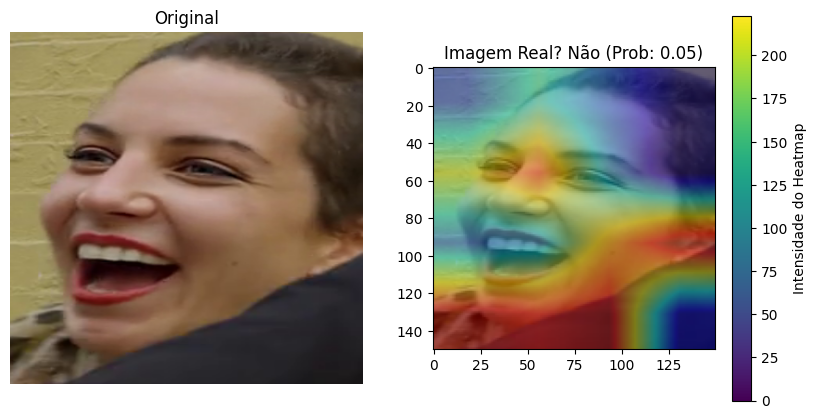

In [ ]:
#model = load_model('/content/drive/MyDrive/TCC-Dataset/modelo_treinado.h5')
img_path = '/content/drive/MyDrive/TCC-Dataset/backup/test/fake/0_01_27__hugging_happy__ZYCZ30C0_61.png'
grad_model = Model(inputs=enhanced_model.inputs, outputs=[enhanced_model.get_layer('conv2d_3').output, enhanced_model.output])

# Pré-processa a imagem
img_array = prepare_image(img_path)

# Predição + Heatmap
conv_outputs, pred = grad_model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, grad_model)

# Visualização
superimposed_img = superimpose_heatmap(img_path, heatmap)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.colorbar(label='Intensidade do Heatmap')
plt.title(f'Imagem Real? {"Sim" if pred[0][0] > 0.5 else "Não"} (Prob: {pred[0][0]:.2f})')

Feature maps

1/1 [==============================] - 0s 134ms/step


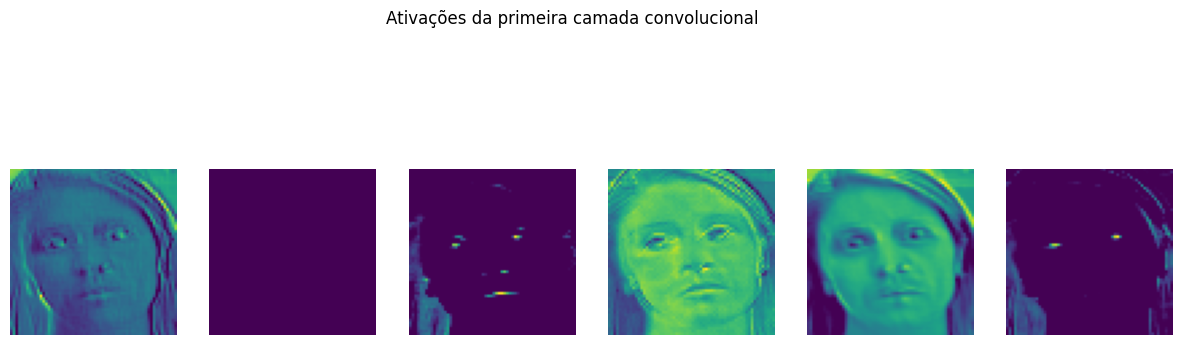

In [ ]:
layer_outputs = [layer.output for layer in new_model.layers if 'conv' in layer.name]
activation_model = Model(inputs=new_model.input, outputs=layer_outputs)

img = next(iter(val_ds))[0][0].numpy()
img_batch = np.expand_dims(img, axis=0)

activations = activation_model.predict(img_batch)

first_layer_activation = activations[0]

plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Ativações da primeira camada convolucional")
plt.show()

Lime explainer

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


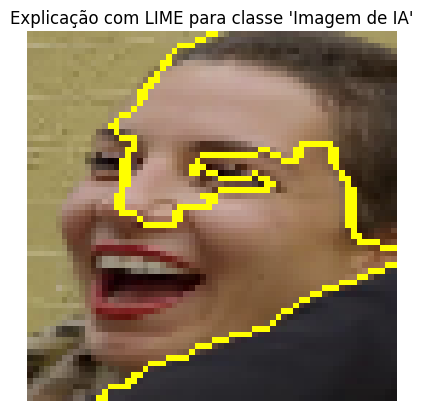

In [ ]:
# Pré-processamento da imagem
def prepare_image(file_path):
    img = tf.keras.utils.load_img(file_path, target_size=(64, 64))
    img = tf.keras.utils.img_to_array(img) / 255.0  # Normaliza para [0, 1]
    return img

def predict_fn(images):
    images = np.array(images)
    return enhanced_model.predict(images)

img = prepare_image('/content/drive/MyDrive/TCC-Dataset/backup/test/fake/0_01_27__hugging_happy__ZYCZ30C0_61.png')

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualização
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=6,
    min_weight=0.01
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("Explicação com LIME para classe 'Imagem de IA'")
plt.axis('off')
plt.show()